# A first example
This is a first example of how to use lettuce.
A two dimensional Taylor Green vortex is initialized and simulated for 10000 steps. Afterwards the energy and the velocity field is plotted.

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

In [2]:
context = lt.Context(device=torch.device('cuda:0') if torch.cuda
                     .is_available() else torch.device('cpu'),
                     dtype=torch.float32, use_native = False)
flow = lt.SuperReducedTaylorGreenVortex3D(resolution=20,reynolds_number=400,
                            mach_number=0.1, stencil=lt.D3Q27,
                            context=context)
collision = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu)
energyreporter = lt.ObservableReporter(lt.IncompressibleKineticEnergy(flow), interval=10, out=None)
simulation = lt.SimulationReducedTGV(flow=flow, collision=collision, reporter=[energyreporter])

steps     time     IncompressibleKineticEnergy


* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

## Run simulation

In [3]:
mlups = simulation(4000)
print("Performance in MLUPS:", mlups)

Performance in MLUPS: 2.467690713267053


## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

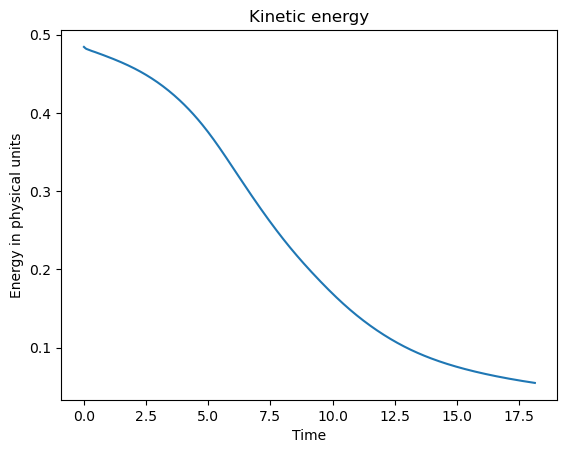

In [4]:
"""Alle Observablen umgerechnet auf den originalen TGV"""
energy = np.array(simulation.reporter[0].out)
plt.plot(energy[:, 1], energy[:, 2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()
dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])

"""Diss = - dEkin/dt mithilfe Differenzenquotient 6. Ordnung mit Randwerten 4., 2., 1. Ordnung"""

for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt

dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*0.5)**3])


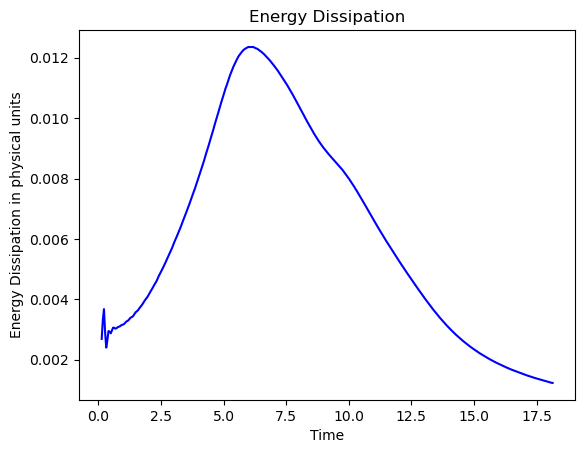

In [5]:

plt.plot(dissipationEkin[0,3:],dissipationEkin[1,3:],color = 'blue')
plt.title('Energy Dissipation')
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()